<a href="https://colab.research.google.com/github/kudosGan/-Exercise/blob/master/trash_data_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New_Trash_Image classification from scratch

**Author:** Kudas
**Date created:** 2020/08/10<br>
**Last modified:** 2020/08/12<br>
**Description:** Training an image classifier from scratch Data stored in the  Google Drive 

## Setup


In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


## Load the data: Timcups and Bottles dataset






In [6]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Generate a `Dataset`


In [8]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/My Drive/trashdata",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/My Drive/trashdata",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 57 files belonging to 2 classes.
Using 46 files for training.
Found 57 files belonging to 2 classes.
Using 11 files for validation.


## Visualize the data

Here are the first 9 images in the training dataset. As you can see, label 1 is "timcups"
 and label 0 is "bottles".


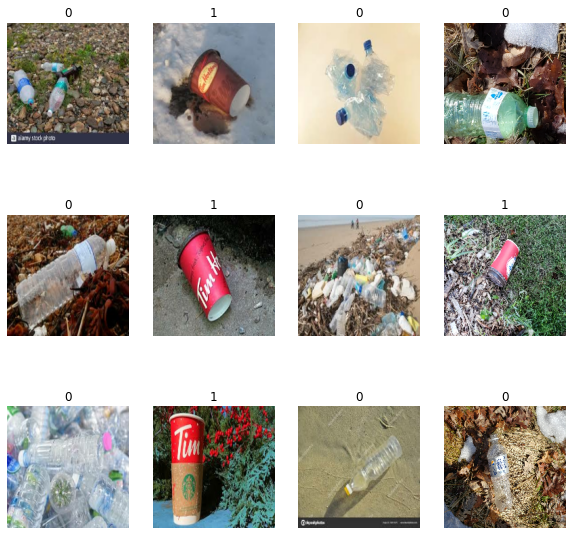

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


## Using image data augmentation



In [12]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)


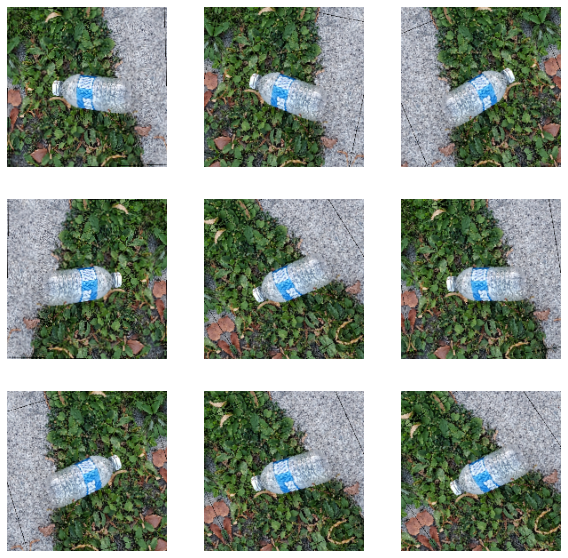

In [14]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


## Configure the dataset for performance

## Build a model



Note that:

- We start the model with the `data_augmentation` preprocessor, followed by a
 `Rescaling` layer.
- We include a `Dropout` layer before the final classification layer.


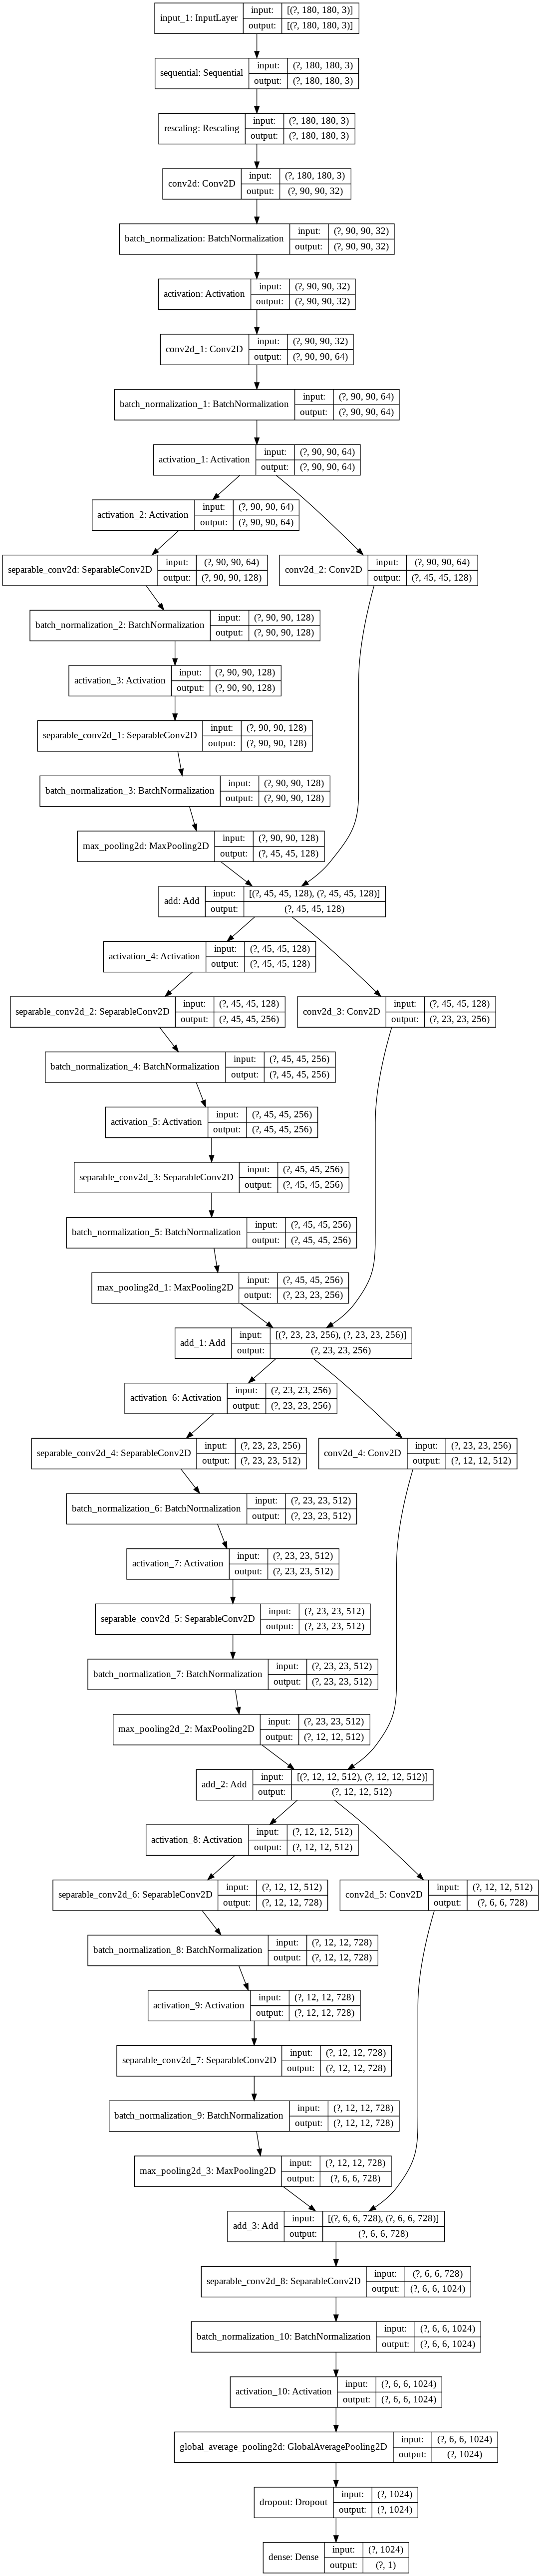

In [15]:

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)


## Train the model


In [16]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)


Epoch 1/50
2/2 [==============================] - 9s 4s/step - loss: 1.0067 - accuracy: 0.5435 - val_loss: 0.6954 - val_accuracy: 0.3636
Epoch 2/50
2/2 [==============================] - 4s 2s/step - loss: 0.4709 - accuracy: 0.7826 - val_loss: 0.6968 - val_accuracy: 0.3636
Epoch 3/50
2/2 [==============================] - 5s 2s/step - loss: 0.2729 - accuracy: 0.8696 - val_loss: 0.6985 - val_accuracy: 0.3636
Epoch 4/50
2/2 [==============================] - 5s 2s/step - loss: 0.1938 - accuracy: 0.9130 - val_loss: 0.6990 - val_accuracy: 0.3636
Epoch 5/50
2/2 [==============================] - 5s 2s/step - loss: 0.1583 - accuracy: 0.9783 - val_loss: 0.6985 - val_accuracy: 0.3636
Epoch 6/50
2/2 [==============================] - 5s 2s/step - loss: 0.1019 - accuracy: 0.9348 - val_loss: 0.6966 - val_accuracy: 0.3636
Epoch 7/50
2/2 [==============================] - 5s 2s/step - loss: 0.0735 - accuracy: 0.9565 - val_loss: 0.6968 - val_accuracy: 0.3636
Epoch 8/50
2/2 [=========================

We get to ~96% validation accuracy after training for 50 epochs on the full dataset.


## Run inference on new data

Note that data augmentation and dropout are inactive at inference time.


In [26]:
img = keras.preprocessing.image.load_img(
    "/content/drive/My Drive/tester1.jpeg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent bottle and %.2f percent timcups."
    % (100 * (1 - score), 100 * score)
)
print (predictions)

This image is 47.42 percent bottle and 52.58 percent timcups.
[[0.5258]]
